In [57]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
import numpy as np
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [58]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
        

# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)

In [59]:
# Configure the index vectors
num_k_per_dim = 20
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0) # Fourier
hk_list = np.zeros(ks.shape[0])

In [60]:
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk
# compute the coefficients for the target distribution Fourier
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    fk_vals /= hk
    phik = np.sum(fk_vals * pdf_vals) * dx * dy 
    phik_list[i] = phik

In [61]:
def compute_indicator_ball_transform_and_grad(xt, r, ks, L_list, hk_list):
    """
    Compute Fourier transform and gradient of a normalized indicator function over a ball.
    
    Parameters:
    - xy: (2,) array, center of ball [x, y]
    - r: float, radius of the ball
    - ks: (N, 2), array of (K1, K2) wave numbers
    - L_list: (2,), spatial domain lengths [L1, L2]
    - hk_list: (N,), normalization constants
    
    Returns:
    - phi_k: (N,), Fourier transform coefficients
    - grad: (N, 2), gradient of phi_k w.r.t. x and y
    """
    x, y = xt
    k1 = ks[:, 0] * np.pi / L_list[0]
    k2 = ks[:, 1] * np.pi / L_list[1]
    k_norm = np.sqrt(k1**2 + k2**2)
    
    # Avoid division by zero
    k_norm_safe = np.where(k_norm == 0, 1e-8, k_norm)
    
    cos1 = np.cos(k1 * x)
    cos2 = np.cos(k2 * y)
    sin1 = np.sin(k1 * x)
    sin2 = np.sin(k2 * y)
    
    # Normalized Bessel term
    bessel_term = (2 / (r * k_norm_safe)) * j1(r * k_norm_safe)
    bessel_term = np.where(k_norm == 0, 1.0, bessel_term)  # value at k=0
    
    phi_k = (bessel_term * cos1 * cos2) / hk_list
    
    dphi_dx = (-k1 * sin1 * cos2) * bessel_term / hk_list
    dphi_dy = (-k2 * cos1 * sin2) * bessel_term / hk_list
    grad = np.stack([dphi_dx, dphi_dy], axis=0)

    return phi_k, grad

def agent_movement(r, ks, L_list, hk_list):
    alpha_1 = ks[:, 0] * np.pi / L_list[0]
    alpha_2 = ks[:, 1] * np.pi / L_list[1]

    q = np.sqrt(alpha_1**2 + alpha_2**2)

    # Avoid division by zero for the zero frequency term
    q_safe = np.where(q == 0, 1e-16, q)

    # Compute multiplier M_k = (2 / (r * q)) * J_1(r * q)
    M_k = (2 / (r * q_safe)) * j1(r * q_safe)

    # Handle the zero-frequency term limit: lim_{q->0} (2/(r q)) J_1(r q) = 1
    M_k = np.where(q == 0, 1.0, M_k)

    # Multiply initial Fourier coefficients by the multiplier and normalize by h_k
    p_hat = (M_k / hk_list)
    return p_hat

#### Recantangular indicator
def compute_fourier_coeffs_and_derivs(xt,r,L, ks, hk ):
    x1, x2 = xt
    L1, L2 = L
    K1s, K2s = ks[:, 0], ks[:, 1]
    
    k1_vals = K1s * np.pi / L_list[0]
    k2_vals = K2s * np.pi / L_list[1]

    # Main coefficient terms
    s1 = np.where(k1_vals != 0,
                  (np.sin(k1_vals * (x1 + r)) - np.sin(k1_vals * (x1 - r))) / k1_vals,
                  2 * r)
    s2 = np.where(k2_vals != 0,
                  (np.sin(k2_vals * (x2 + r)) - np.sin(k2_vals * (x2 - r))) / k2_vals,
                  2 * r)
    coeffs = (s1 * s2) / hk * (1 / (2 * r)** 2)

    # Derivatives with safe handling
    dc_dx1 = np.where(k1_vals != 0,
                      (np.cos(k1_vals * (x1 + r)) - np.cos(k1_vals * (x1 - r))) * s2 / hk,
                      0.0)
    dc_dx2 = np.where(k2_vals != 0,
                      s1 * (np.cos(k2_vals * (x2 + r)) - np.cos(k2_vals * (x2 - r))) / hk,
                      0.0)

    return coeffs, np.stack([dc_dx1, dc_dx2], axis=0)
#compute_fourier_coeffs_and_derivs(np.random.uniform(low=0.2, high=0.8, size=(2,)), 0.1,L_list, ks, hk_list)[0], hk_list

def gaussian_inner_product(x_t, c_ks, sigma, Cov):
    """
    Compute <f_k, p(x | x_t)> for many c_k
    x_t: (2,) — current point x_t = g(tau)
    c_ks: (N, 2) — list of c_k points
    sigma2: scalar
    Sigma: (2,2) — covariance matrix of the Gaussian
    Returns:
        (N,) — scalar inner products per c_k
    """
    I = np.eye(2)
    Cov_inv = np.linalg.inv(Cov)
    M_inv = np.linalg.inv((1/sigma**2)*I + Cov_inv)

    diffs = c_ks - x_t[None, :]  # shape (N, 2)
    exps = np.einsum('ni,ij,nj->n', diffs, M_inv, diffs)  # Mahalanobis distance
    const = (1.0 / (np.sqrt(np.linalg.det(Cov))) * np.sqrt(np.linalg.det((1/sigma**2)*I + Cov)))
    return const * np.exp(-0.5 * exps)

def d_gaussian_inner_product_dx(x_t, ip_vals, c_ks, sigma, Cov):
    """
    Compute gradient of <f_k, p(x | x_t)> wrt x_t for many c_k
    Returns:
        (N, 2) — gradient of inner product wrt x_t
    """
    I = np.eye(2)
    Cov_inv = np.linalg.inv(Cov)
    M_inv = np.linalg.inv((1/sigma**2)*I + Cov_inv)
  # shape (N,)
    diffs = c_ks - x_t[None, :]                                 # shape (N, 2)
    grads = ip_vals[:, None] * (M_inv @ diffs.T).T              # shape (N, 2)
    return grads

In [62]:
def compute_ball_kernel_coeff_mc(k, L_list, r, n_samples=100000):
    """
    Approximate Fourier cosine coefficients of the uniform ball kernel using Monte Carlo.

    Parameters:
    - k: (N, 2) array of frequency indices
    - L_list: [Lx, Ly]
    - r: radius of the ball
    - n_samples: number of Monte Carlo samples

    Returns:
    - coeffs: (N,) array of Fourier cosine coefficients
    """
    Lx, Ly = L_list
    cx, cy = Lx/2, Ly/2

    # Sample uniformly inside a ball
    theta = 2 * np.pi * np.random.rand(n_samples)
    rho = r * np.sqrt(np.random.rand(n_samples))  # to ensure uniform density
    xs = cx + rho * np.cos(theta)
    ys = cy + rho * np.sin(theta)

    # Remove samples outside domain just in case
    valid = (xs >= 0) & (xs <= Lx) & (ys >= 0) & (ys <= Ly)
    xs = xs[valid]
    ys = ys[valid]

    coeffs = []
    for k1, k2 in k:
        basis_vals = np.cos(k1 * np.pi * xs / Lx) * np.cos(k2 * np.pi * ys / Ly)
        coeff = np.mean(basis_vals)
        print(basis_vals)
        #if k1 == 0 and k2 == 0:
        #    coeff = 1.0  # integral over uniform ball = 1
        coeffs.append(coeff)

    return np.array(coeffs)


In [ ]:
# Specify the dynamic system 
dt = 0.01
tsteps = 10000
ud = 0.2  # desired velocity 0.2 m/s
r = 0.1
target_velocity = 0.01
precomputed_coeffs = compute_ball_kernel_coeff_mc(ks, L_list, dt * target_velocity, n_samples = 10000)
print(precomputed_coeffs)

[1. 1. 1. ... 1. 1. 1.]
[ 2.2668e-04 -2.1327e-05 -1.3023e-04 ... -5.5324e-05 -1.2288e-04
  1.0864e-05]
[-1. -1. -1. ... -1. -1. -1.]
[-6.8005e-04  6.3981e-05  3.9070e-04 ...  1.6597e-04  3.6864e-04
 -3.2591e-05]
[1. 1. 1. ... 1. 1. 1.]
[ 1.1334e-03 -1.0664e-04 -6.5116e-04 ... -2.7662e-04 -6.1439e-04
  5.4318e-05]
[-1. -1. -1. ... -1. -1. -1.]
[-1.5868e-03  1.4929e-04  9.1163e-04 ...  3.8727e-04  8.6015e-04
 -7.6045e-05]
[1. 1. 1. ... 1. 1. 1.]
[ 2.0401e-03 -1.9194e-04 -1.1721e-03 ... -4.9792e-04 -1.1059e-03
  9.7773e-05]
[-1. -1. -1. ... -1. -1. -1.]
[-0.0025  0.0002  0.0014 ...  0.0006  0.0014 -0.0001]
[1. 1. 1. ... 1. 1. 1.]
[ 0.0029 -0.0003 -0.0017 ... -0.0007 -0.0016  0.0001]
[-1. -1. -1. ... -1. -1. -1.]
[-0.0034  0.0003  0.002  ...  0.0008  0.0018 -0.0002]
[1. 1. 1. ... 1. 1. 1.]
[ 0.0039 -0.0004 -0.0022 ... -0.0009 -0.0021  0.0002]
[-1. -1. -1. ... -1. -1. -1.]
[-0.0043  0.0004  0.0025 ...  0.0011  0.0023 -0.0002]
[-7.4841e-05  1.1758e-04  4.2352e-05 ...  1.1872e-04 -2.4719e-04


In [64]:
def dyn(xt, ut):
    xdot = ut 
    return ut

def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)
    return xt_new 
# start SMC iteration
xt = np.random.uniform(low=0.2, high=0.8, size=(2,)) # inital state
x_traj = np.zeros((tsteps, 2)) # trajectory
ck_list_update = np.zeros(ks.shape[0])  # trajectory coefficients (update over time, not normalized)
metric_log = []  # record ergodic metric at each step
for t in range(tsteps):   
    #### Kernalized Radial wrt Gaussian
    #fk_xt_all = gaussian_inner_product(xt, centers, sigma, Cov )
    #dfk_xt_all = d_gaussian_inner_product_dx(xt,fk_xt_all,centers,sigma,Cov).T
    
    #Kernalized Fourier wrt gaussian
    ### I have written, why .shape in exp????
    #fk_xt_all = np.exp(-0.5 * ((np.pi * ks / L_list.shape)**2) @ var) * (np.prod(np.cos(np.pi * ks / L_list * xt), axis=1) / hk_list)
    #dfk_xt_all = np.array([
    #    -np.pi * ks[:,0] / L_list[0] * np.sin(np.pi * ks[:,0] / L_list[0] * xt[0]) * np.cos(np.pi * ks[:,1] / L_list[1] * xt[1]),
    #    -np.pi * ks[:,1] / L_list[1] * np.cos(np.pi * ks[:,0] / L_list[0] * xt[0]) * np.sin(np.pi * ks[:,1] / L_list[1] * xt[1]),
    #]) * (np.exp(-0.5 * (np.pi * ks / L_list.shape) @ var) / hk_list)"""

    #### Kernalized Fourier wrt to INdicator of A := {x:||x - xt||_{\inf} \leq r}
    fk_xt_all, dfk_xt_all = compute_fourier_coeffs_and_derivs(xt, r,L_list, ks, hk_list)
    ck_list_update += fk_xt_all * dt

    ### Kernalized Fourier with respect to Indicator of Ball centered at xt
    #fk_xt_all, dfk_xt_all = compute_indicator_ball_transform_and_grad(xt, r, ks, L_list, hk_list)
    #ck_list_update += fk_xt_all * dt

    # step 4: compute control signal
    bt = np.sum(lamk_list * ((ck_list_update / (t*dt+dt)) - phik_list) * dfk_xt_all, axis=1)
    ut = -ud * bt / np.linalg.norm(bt)
    # print('ut: ', np.linalg.norm(ut))
    ## update target believe
    #print(agent_movement(xt, dt * target_velocity, ks, L_list, hk_list))
    phik_list *= precomputed_coeffs
    #phik_list /= np.sum(phik_list) ## preserving some energy
    
    # step 5: execute the control, move on to the next iteration
    xt_new = step(xt, ut)
    xt = xt_new.copy()
    x_traj[t] = xt.copy()
    
    erg_metric = np.sum(np.square(phik_list - ck_list_update / (t*dt+dt)))
    metric_log.append(erg_metric)
    if t % 1000 == 0:
        print(f"Step {t}, Position: {xt[:2]}, Metric: {erg_metric:.5f}")

C:\Users\JP\AppData\Local\Temp\ipykernel_53236\616330709.py:71: RuntimeWarning: invalid value encountered in divide
  (np.sin(k1_vals * (x1 + r)) - np.sin(k1_vals * (x1 - r))) / k1_vals,
C:\Users\JP\AppData\Local\Temp\ipykernel_53236\616330709.py:74: RuntimeWarning: invalid value encountered in divide
  (np.sin(k2_vals * (x2 + r)) - np.sin(k2_vals * (x2 - r))) / k2_vals,


Step 0, Position: [0.538  0.4986], Metric: 24.06626
Step 1000, Position: [0.7563 0.7608], Metric: 2.96872
Step 2000, Position: [0.1972 0.3012], Metric: 2.30524
Step 3000, Position: [0.5341 0.6448], Metric: 2.36673
Step 4000, Position: [0.6854 0.6029], Metric: 2.73895
Step 5000, Position: [0.9286 0.9713], Metric: 2.66092
Step 6000, Position: [0.5607 0.9567], Metric: 2.07530
Step 7000, Position: [0.1955 0.8473], Metric: 1.66630
Step 8000, Position: [2.2821e-09 8.8894e-01], Metric: 1.43454
Step 9000, Position: [0.2155 0.1848], Metric: 1.30025


In [65]:
def indicator_pdf_from_trajectory(x_traj, r, grid_res=200):
    """
    Approximate time-averaged density from trajectory using indicator functions.
    
    Parameters:
        x_traj: np.ndarray of shape (T, 2) – the trajectory
        r: float – half-width of square for indicator
        grid_res: int – resolution of the evaluation grid in each dimension
    
    Returns:
        X, Y: grid coordinates
        density: estimated density on the grid
    """
    T = x_traj.shape[0]
    
    # Set up grid
    x_min, x_max = 0. , 1.
    y_min, y_max = 0. , 1.
    x = np.linspace(x_min, x_max, grid_res)
    y = np.linspace(y_min, y_max, grid_res)
    X, Y = np.meshgrid(x, y)
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=-1)  # shape (grid_res², 2)
    
    # Evaluate indicator for each xt
    density = np.zeros(grid_points.shape[0])
    
    for xt in x_traj:
        in_square = np.all(np.abs(grid_points - xt) < r, axis=1)
        density[in_square] += 1 / (4 * r**2 * T)
    
    return X, Y, density.reshape(grid_res, grid_res)

# Example usage
grids_x_emp, grids_y_emp, empirical_density = indicator_pdf_from_trajectory(x_traj, r)

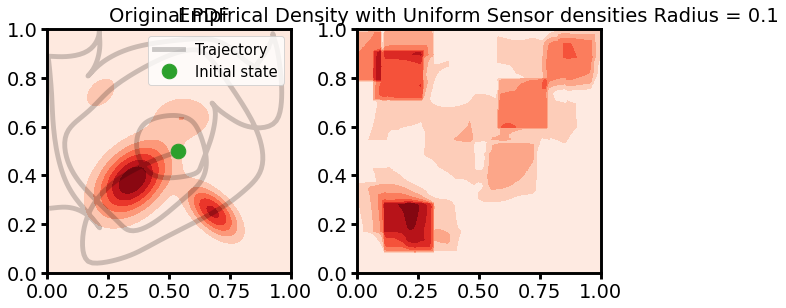

In [66]:
# reconstruct the emprical distribution
#phi_recon = np.zeros(grids.shape[0])
from scipy.spatial.distance import cdist
from numpy.linalg import solve

# visualize the trajectory
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
#fig, axes = plt.subplots(figsize=(6, 4), dpi=100, tight_layout=True) #### For now only one plot as i do not wish to reconstruct.
ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
ax.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2, label='Trajectory')
ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0, label='Initial state')
ax.legend(loc=1)

#### Empirical density using pdfs other than dirac
ax2 = axes[1]
ax2.set_aspect('equal')
ax2.set_xlim(0.0, L_list[0])
ax2.set_ylim(0.0, L_list[1])
ax2.set_title(f'Empirical Density with Uniform Sensor densities Radius = {r}')
ax2.contourf(grids_x_emp, grids_y_emp, empirical_density.reshape(grids_x_emp.shape), cmap='Reds')
#ax2.plot(x_traj[::10,0], x_traj[::10,1], linestyle='-', marker='', color='k', alpha=0.2)
#ax2.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2', alpha=1.0)

plt.show()
plt.close()

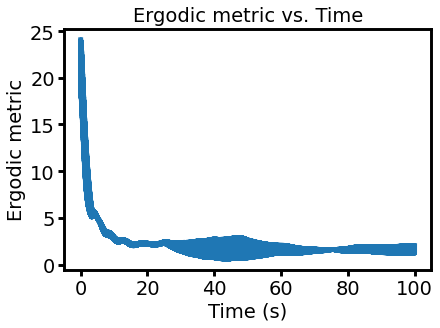

In [67]:
# Also visualize the ergodic metric over time
fig, ax = plt.subplots(1, 1, dpi=70, tight_layout=True)

ax.plot(np.arange(tsteps)*dt, metric_log)
ax.set_title('Ergodic metric vs. Time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Ergodic metric')

plt.show()
plt.close()

KeyboardInterrupt: 

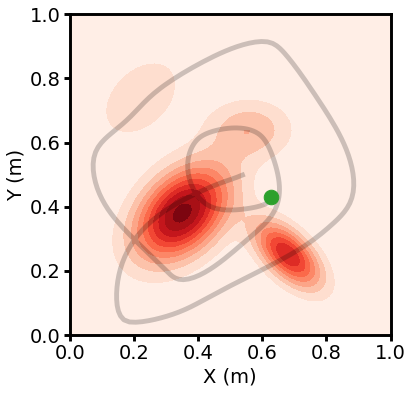

In [68]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', levels=10)

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 10)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::10], x_traj[:t,1][::10]
    )

    return robot_state, robot_traj,

ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/10)-1, blit=True, interval=30, repeat=False)
video = ani.to_html5_video()
HTML(video)

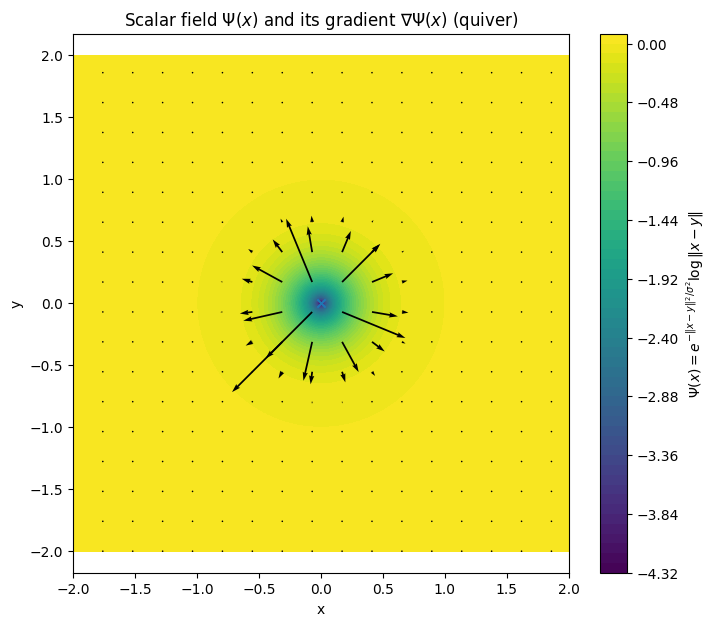


Analytic gradient (componentwise) for Psi(x) = w(x) * log(||x-y||), with 
w(x) = exp(-||x-y||^2 / sigma^2), r = ||x-y||:
  grad w(x) = w(x) * (-2/sigma^2) * (x - y)
  grad log r = (x - y) / r^2  (regularize at r=0)
=> grad Psi(x) = grad w(x) * log r + w(x) * grad log r
                 = w(x) * [ (-2/sigma^2) * (x-y) * log r  +  (x-y)/r^2 ]



In [1]:
# Exact gradient of Psi_k(x) and visualization
import numpy as np
import matplotlib.pyplot as plt

# Parameters
sigma = 0.5
y = np.array([0.0, 0.0])  # y_k
eps = 1e-8  # regularization to avoid singularities

# Grid for plotting
nx = 200
xs = np.linspace(-2.0, 2.0, nx)
ys = np.linspace(-2.0, 2.0, nx)
X, Y = np.meshgrid(xs, ys)
pos = np.stack([X, Y], axis=-1)

# helper arrays
V = pos - y  # vector from y to x, shape (nx, nx, 2)
dist2 = np.sum(V**2, axis=-1)  # r^2
r = np.sqrt(dist2 + eps)

# scalar weight and potential
w = np.exp(-dist2 / sigma**2)
Psi = w * np.log(r + eps)  # Psi_k(x) = w(x) * log||x - y||

# exact gradient components
# grad w = w * (-2/sigma^2) * (x - y)
grad_w = w[..., None] * (-2.0 / sigma**2) * V  # shape (nx, nx, 2)
# grad log r = (x-y) / (r^2)  (we add eps in denom for stability)
grad_logr = V / (dist2[..., None] + eps)
# product rule: grad Psi = grad_w * log r + w * grad_logr
logr = np.log(r + eps)
grad_Psi = grad_w * logr[..., None] + w[..., None] * grad_logr  # shape (nx, nx, 2)

# Prepare a quiver that is not too dense to keep plot readable
step = 12
U = grad_Psi[..., 0]
W = grad_Psi[..., 1]

# Plot scalar field (contours) and gradient field (quiver)
plt.figure(figsize=(8, 7))
plt.contourf(X, Y, Psi, levels=60)
plt.colorbar(label=r'$\Psi(x)=e^{-\|x-y\|^2/\sigma^2}\log\|x-y\|$')
plt.quiver(X[::step, ::step], Y[::step, ::step], U[::step, ::step], W[::step, ::step], scale=50)
plt.scatter([y[0]], [y[1]], marker='x')
plt.title(r'Scalar field $\Psi(x)$ and its gradient $\nabla\Psi(x)$ (quiver)')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

# For convenience, print the analytic expression as text (human-readable)
analytic = r"""
Analytic gradient (componentwise) for Psi(x) = w(x) * log(||x-y||), with 
w(x) = exp(-||x-y||^2 / sigma^2), r = ||x-y||:
  grad w(x) = w(x) * (-2/sigma^2) * (x - y)
  grad log r = (x - y) / r^2  (regularize at r=0)
=> grad Psi(x) = grad w(x) * log r + w(x) * grad log r
                 = w(x) * [ (-2/sigma^2) * (x-y) * log r  +  (x-y)/r^2 ]
"""
print(analytic)
